# Predictive Sales Forecasting for a Mobile Shop: Leveraging Time Series Analysis for Improved Business Insights

## Abstract:

This project focuses on predictive sales forecasting for a mobile shop using time series analysis and two different modeling approaches: FBProphet and XGBoost. The objective is to develop accurate forecasting models to gain insights into future sales trends and improve business decision-making. The FBProphet model achieved a MAPE of 0.12%, while XGBoost obtained a significantly lower MAPE of 0.11%. The study emphasizes the value of leveraging advanced machine learning models to enhance business analytics and optimize inventory management in the dynamic mobile market landscape.

## Objective

The objective of this project is to develop accurate sales forecasting models for a mobile shop using time series analysis. The study employs two distinct approaches, FBProphet and XGBoost, to predict future sales trends. By comparing the models' performance in terms of Mean Absolute Percentage Error (MAPE), the project aims to identify the most suitable forecasting technique.

## Table of Contents

* [XGBoost Model](#section-1)
    * [Exploratory Data Analysis](#section-1.1)
    * [Time Series Split](#section-1.2)
    * [Time Series Cross-Validation: Train-Test Splits Visualization](#section-1.3)
    * [Data Preprocessing ](#section-1.4)
    * [Cross Validation](#section-1.5)
    * [Hyperparameter Tuning](#section-1.6)
    * [Future Sales Predictions ](#section-1.7)
    * [Predictions on Test Dataset](#section-1.8)
    * [Comparison of Daily Sales Data and Predictions](#section-1.9)
    * [Model Evaluation](#section-1.10)
    * [Conclusion on XG Boost](#section-1.11)
* [FB Prophet](#section-2)
    * [Exploratory Data Analysis](#section-2.1)
    * [Feature Engineering](#section-2.2)
    * [Train - Test Split](#section-2.3)
    * [Model Fitting](#section-2.4)
    * [Model Prediction](#section-2.5)
    * [Comparing Forecast to Originals](#section-2.6)
    * [Model Evaluation](#section-2.7)
    * [Future Prediction](#section-2.8)
* [Conclusion](#section-3)
* [References](#section-4)


## XGBoost Model
<a id='section-1'></a>

In [72]:
#Importing all necessary libraries and packeages
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import xgboost as xgb
color_pal = sns.color_palette()
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
plt.style.use('fivethirtyeight')

In [73]:
#Loading the dataset
df = pd.read_csv('sales_dataset.csv')
print(df.shape)
df.head()

(789, 2)


,Date,Daily Sales
0,2019-10-01,11756.0
1,2019-10-03,11988.0
2,2019-10-04,16695.0
3,2019-10-07,13618.0
4,2019-10-08,12805.0


In [74]:
# Set the 'Date' column as the index of the DataFrame
df = df.set_index('Date')


# Convert the index to a datetime data type
df.index = pd.to_datetime(df.index)

## Exploratory Data Analysis
<a id='section-1.1'></a>

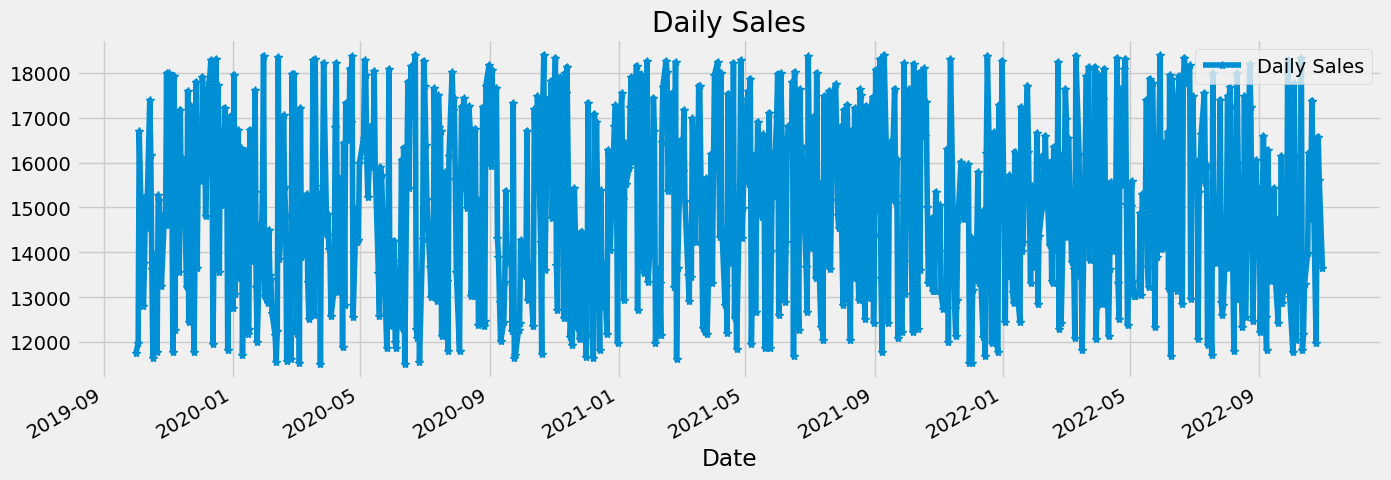

In [75]:
# Let's visualize the distribution of the data
df.plot(style='-*', color = color_pal[0],
        figsize=(15,5),title='Daily Sales')
plt.show()

## Time Series Split
<a id='section-1.2'></a>

In [76]:
# Initialize a TimeSeriesSplit object
# - n_splits: Number of splits (folds) for cross-validation
# - test_size: Size of the test set in each split (in this case, 30 time steps)
# - gap: Number of time steps between the end of the training set and the start of the test set
tss = TimeSeriesSplit(n_splits=5, test_size=30, gap=1)

# Sort the DataFrame by the index (in this case, the 'Date' column)
# Sorting the data by time ensures proper chronological order for time series analysis
df = df.sort_index()


### Time Series Cross-Validation: Train-Test Splits Visualization
<a id='section-1.3'></a>

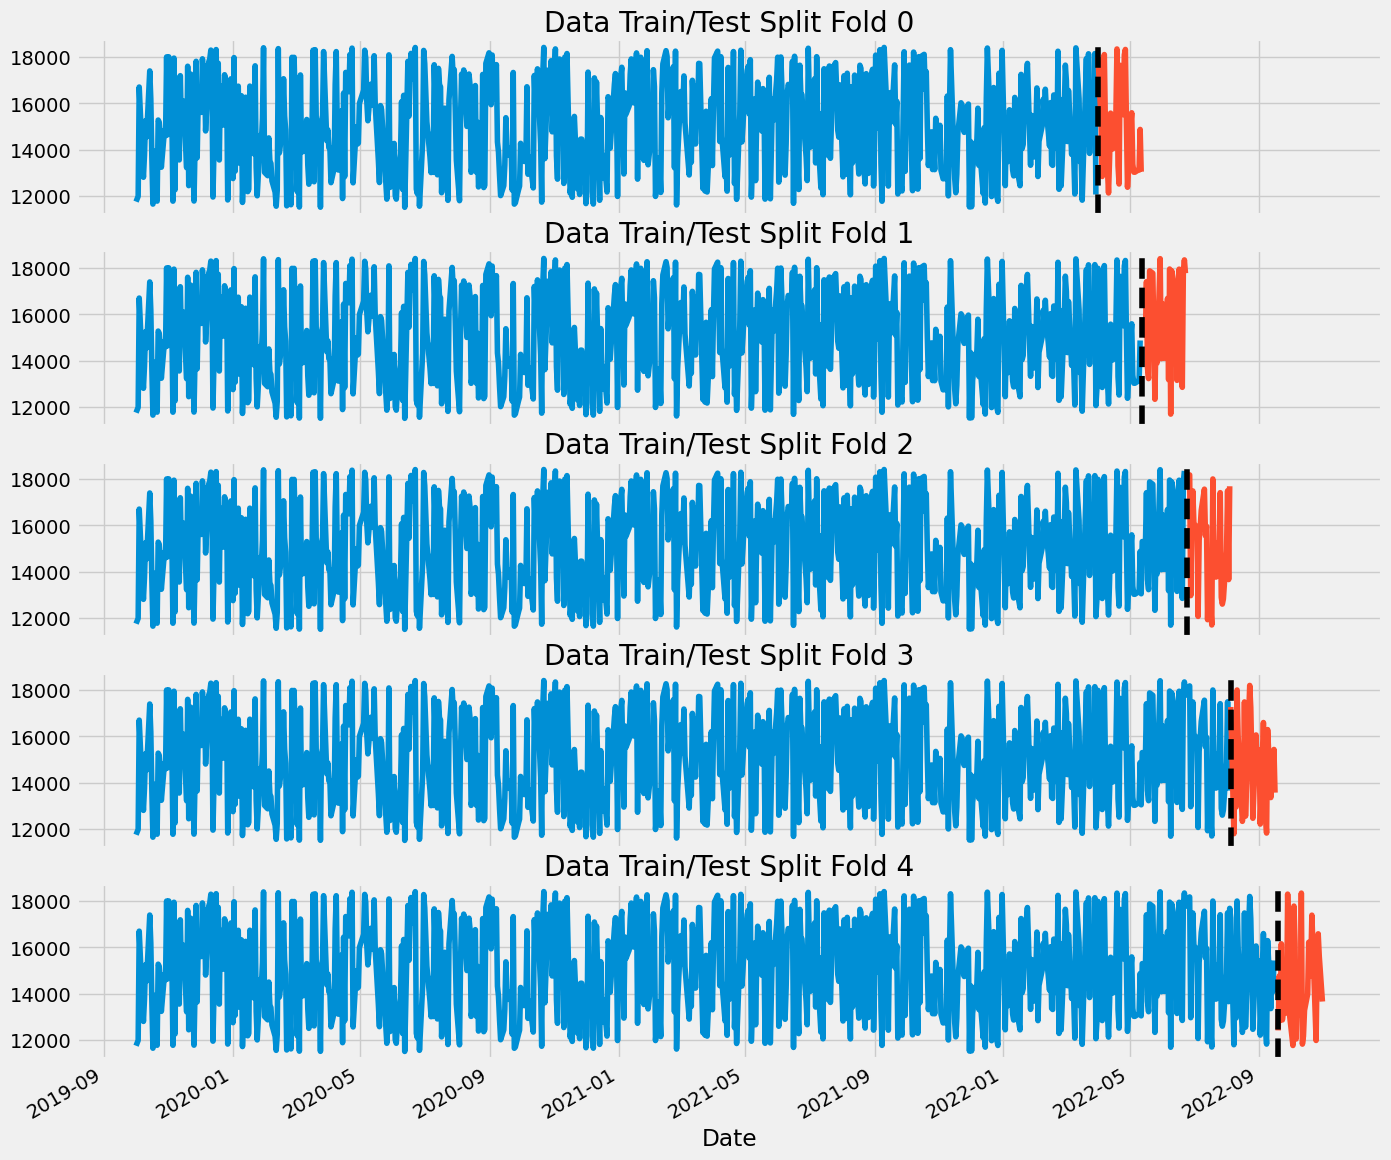

In [77]:

# 'tss' is the TimeSeriesSplit object created previously

# Import the necessary libraries
import matplotlib.pyplot as plt

# Create a 5x1 subplot for visualizing the train-test splits
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

# Initialize the fold counter
fold = 0

# Iterate through the TimeSeriesSplit splits and plot the train-test splits
for train_idx, val_idx in tss.split(df):
    # Extract the training and test sets based on the split indices
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    # Plot the 'Daily Sales' for the training set
    train['Daily Sales'].plot(ax=axs[fold],
                              label='Training Set',
                              title=f'Data Train/Test Split Fold {fold}')
    
    # Plot the 'Daily Sales' for the test set
    test['Daily Sales'].plot(ax=axs[fold],
                             label='Test Set')
    
    # Add a vertical line to indicate the separation between training and test sets
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    
    # Increment the fold counter
    fold += 1
    
    # Break the loop after 5 folds (for illustration purposes)
    if fold == 5:
        break

# Display the plots
plt.show()


In the code above, we use matplotlib to create a 5x1 subplot to visualize the train-test splits generated by the TimeSeriesSplit object. The tss.split(df) method returns a sequence of training and test set indices for each fold, and we use these indices to extract the corresponding data from the DataFrame df.

For each fold, we plot the 'Daily Sales' values of the training and test sets in separate subplots. We also add a vertical dashed line at the point where the training set ends and the test set starts, visually indicating the train-test split.

By plotting the train-test splits, we can visualize how the data is divided for each fold in the time series cross-validation process. This helps us understand how the model is trained and tested on different subsets of the time series data.

## Data Preprocessing 
<a id='section-1.4'></a>
### Time Index and Feature Engineering

In [78]:


def Feature_creation(df):
    """
    Function to create additional time-based features from the DataFrame index.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the time series data.

    Returns:
        pd.DataFrame: A new DataFrame with additional time-based features.
    """
    # Create a copy of the input DataFrame to avoid modifying the original data
    df = df.copy()

    # Extract time-based features from the DataFrame index
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['Quarter'] = df.index.quarter
    df['Hour'] = df.index.hour
    df['DayOfYear'] = df.index.dayofyear
    df['DayofMonth'] = df.index.day
    df['DayofWeek'] = df.index.dayofweek
    df['Year'] = df.index.year
    df['WeekofYear'] = df.index.isocalendar().week

    return df

# Call the Feature_creation function and assign the result back to 'df'
df = Feature_creation(df)


In the code above, we define a function Feature_creation that takes a DataFrame df as input and creates additional time-based features based on the DataFrame index. The function then returns a new DataFrame with the added features.

The time-based features extracted from the DataFrame index include:

'Year': The year component of the index.
'Month': The month component of the index.
'Quarter': The quarter of the year corresponding to the index.
'Hour': The hour component of the index.
'DayOfYear': The day of the year corresponding to the index.
'DayofMonth': The day of the month corresponding to the index.
'DayofWeek': The day of the week corresponding to the index (Monday is 0 and Sunday is 6).
'WeekofYear': The week of the year corresponding to the index.
The Feature_creation function ensures that the original DataFrame 'df' is not modified by making a copy of it before adding the new features. The function returns the new DataFrame with the additional time-based features, which is then assigned back to 'df' for further analysis and modeling

### Feature Engineering: Lag Creation for Mobile Shop Sales Data

In [79]:
def lag_creation(df):
    """
    Function to create lag features from the 'Daily Sales' column in the DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the time series data.

    Returns:
        pd.DataFrame: A new DataFrame with lag features added.
    """
    # Create a dictionary mapping dates to 'Daily Sales' values for efficient lookup
    target_map = df['Daily Sales'].to_dict()

    # Create lag features by mapping 'Daily Sales' values from previous time periods
    df['lag1'] = (df.index - pd.Timedelta('30 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('60 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('90 days')).map(target_map)
    df['lag4'] = (df.index - pd.Timedelta('120 days')).map(target_map)

    return df

# Call the lag_creation function and assign the result back to 'df'
df = lag_creation(df)


In the code above, we define a function lag_creation that takes a DataFrame df as input and creates lag features based on the 'Daily Sales' column. Lag features are useful in time series forecasting, as they capture past values of the target variable.

The function first creates a dictionary 'target_map' that maps dates to their corresponding 'Daily Sales' values, enabling efficient lookup during lag feature creation.

Next, the function creates four lag features ('lag1', 'lag2', 'lag3', and 'lag4') by mapping 'Daily Sales' values from previous time periods. Each lag feature represents the 'Daily Sales' value from 30, 60, 90, and 120 days ago, respectively.

The function returns a new DataFrame with the lag features added, which is then assigned back to 'df' for further analysis and modeling. These lag features can provide valuable historical information to enhance time series forecasting models for mobile shop sales.

### Monthly Sales Distribution: Box Plot

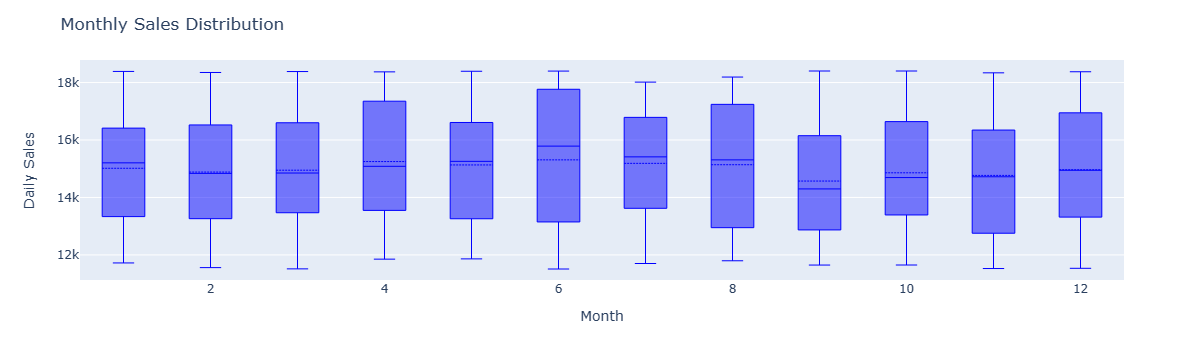

In [80]:

# Create a box plot using Plotly Express
fig = px.box(data_frame=df, x='Month', y='Daily Sales')

# Customize the box plot appearance
fig.update_traces(
    marker=dict(color='black', size=3),
    line=dict(color='blue', width=1),
    boxmean=True
)

# Customize the plot layout
fig.update_layout(
    title='Monthly Sales Distribution',
    xaxis=dict(title='Month'),
    yaxis=dict(title='Daily Sales')
)

# Display the plot
fig.show()


In the code above, we use Plotly Express to create a box plot with 'Month' on the x-axis representing the different months and 'Daily Sales' on the y-axis representing the distribution of sales values.

We customize the appearance of the box plot using update_traces method:

The marker parameter sets the marker color to black with a size of 3.
The line parameter sets the line color to blue with a width of 1.
The boxmean=True parameter displays a line inside each box plot representing the mean value.
We also customize the layout of the plot using update_layout method:

The title parameter sets the plot title to "Monthly Sales Distribution".
The xaxis parameter sets the title of the x-axis to "Month".
The yaxis parameter sets the title of the y-axis to "Daily Sales".
Finally, we display the plot using fig.show(). The resulting box plot shows the distribution of daily sales for each month, along with the mean value represented by the blue line inside each box. This visualization helps identify any seasonal patterns or outliers in the sales data.

### Daily Sales Distribution: Box Plot

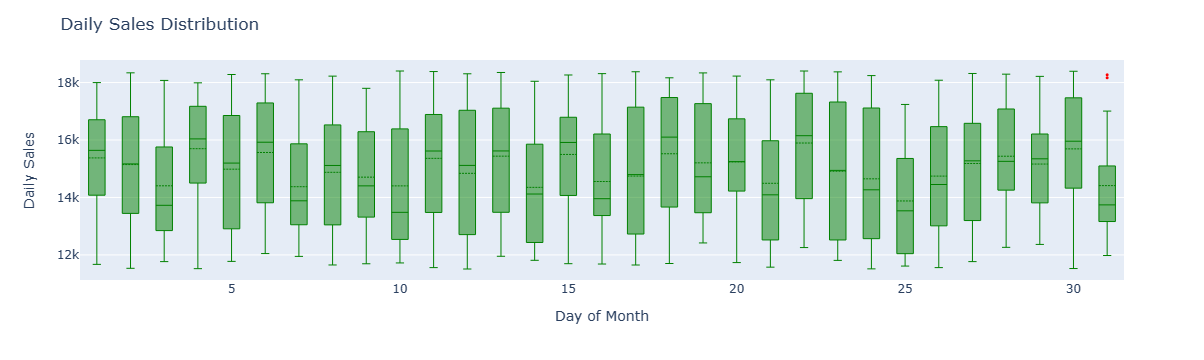

In [81]:

# Create a box plot using Plotly Express
fig = px.box(data_frame=df, x='DayofMonth', y='Daily Sales')

# Customize the box plot appearance
fig.update_traces(
    marker=dict(color='red', size=3),
    line=dict(color='green', width=1),
    boxmean=True
)

# Customize the plot layout
fig.update_layout(
    title='Daily Sales Distribution',
    xaxis=dict(title='Day of Month'),
    yaxis=dict(title='Daily Sales')
)

# Display the plot
fig.show()


In the code above, we use Plotly Express to create a box plot with 'DayofMonth' on the x-axis representing different days of the month and 'Daily Sales' on the y-axis representing the distribution of sales values.

We customize the appearance of the box plot using the update_traces method:

The marker parameter sets the marker color to red with a size of 3.
The line parameter sets the line color to green with a width of 1.
The boxmean=True parameter displays a line inside each box plot representing the mean value.
We also customize the layout of the plot using the update_layout method:

The title parameter sets the plot title to "Daily Sales Distribution".
The xaxis parameter sets the title of the x-axis to "Day of Month".
The yaxis parameter sets the title of the y-axis to "Daily Sales".
Finally, we display the plot using fig.show(). The resulting box plot shows the distribution of daily sales for each day of the month, along with the mean value represented by the green line inside each box. This visualization helps identify any daily sales patterns or outliers in the sales data.

### Revenue by Day of Week: Box Plot

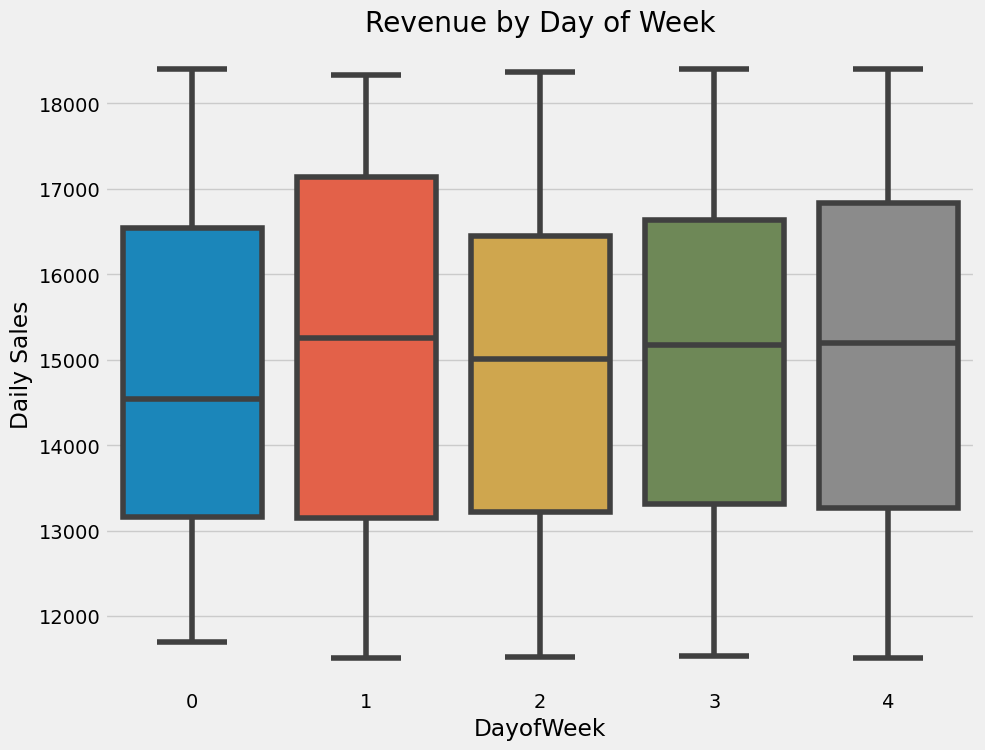

In [82]:

# Create a box plot using Seaborn
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='DayofWeek', y='Daily Sales')

# Set the title of the plot
ax.set_title('Revenue by Day of Week')

# Display the plot
plt.show()


In the code above, we use Seaborn to create a box plot with 'DayofWeek' on the x-axis representing different days of the week and 'Daily Sales' on the y-axis representing the distribution of sales values.

We create the box plot using sns.boxplot:

The data parameter specifies the DataFrame 'df' containing the sales data.
The x parameter specifies the column 'DayofWeek' for the x-axis representing the days of the week.
The y parameter specifies the column 'Daily Sales' for the y-axis representing the sales values.
We customize the layout of the plot by setting the title using ax.set_title. The title is set to "Revenue by Day of Week", indicating that the box plot visualizes the distribution of revenue for each day of the week.

Finally, we display the plot using plt.show(). The resulting box plot shows the distribution of daily sales for each day of the week. This visualization helps identify any weekly sales patterns or variations in revenue throughout the week.

## Cross Validation
<a id='section-1.5'></a>

In [83]:
# Import necessary libraries
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize TimeSeriesSplit object
tss = TimeSeriesSplit(n_splits=5, test_size=30, gap=1)

# Sort the DataFrame by the index (if not already sorted)
df = df.sort_index()

# Initialize empty lists to store predictions and RMSE scores
fold = 0
preds = []
scores = []

# Loop through each fold in the TimeSeriesSplit
for train_idx, val_idx in tss.split(df):
    # Split the data into training and test sets based on the fold indices
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    # Create additional time-based features for training and test sets
    train = Feature_creation(train)
    test = Feature_creation(test)

    # Define the features and target columns for the model
    FEATURES = ['DayOfYear', 'Hour', 'DayofWeek', 'Quarter', 'Month', 'Year', 'lag1', 'lag2', 'lag3', 'lag4']
    TARGET = 'Daily Sales'

    # Separate the features and target variables for training and test sets
    X_train = train[FEATURES]
    y_train = train[TARGET]
    X_test = test[FEATURES]
    y_test = test[TARGET]

    # Initialize and train the XGBoost regression model
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=400,
                           early_stopping_rounds=50, objective='reg:linear',
                           max_depth=3, learning_rate=0.01)
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

    # Make predictions on the test set using the trained model
    y_pred = reg.predict(X_test)
    preds.append(y_pred)

    # Calculate the RMSE score for the fold and store it in 'scores' list
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

    # Increment the fold counter
    fold += 1


[19:59:45] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:14991.59186	validation_1-rmse:14901.58751
[100]	validation_0-rmse:5815.79644	validation_1-rmse:5706.64300
[200]	validation_0-rmse:2796.41899	validation_1-rmse:2766.68729
[300]	validation_0-rmse:2015.02274	validation_1-rmse:2118.44374
[399]	validation_0-rmse:1838.78488	validation_1-rmse:2049.03666
[19:59:47] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:14987.28663	validation_1-rmse:15595.05953
[100]	validation_0-rmse:5813.14247	validation_1-rmse:6390.74932
[200]	validation_0-rmse:2803.15010	validation_1-rmse:3307.93913
[300]	validation_0-rmse:2029.50735	validation_1-rmse:2422.81763
[399]	validation_0-rmse:1854.87067	validation_1-rmse:2192.72951
[19:59:48]

In the code above, we perform a time series cross-validation with 5 folds using TimeSeriesSplit. The data is split into training and test sets for each fold, and XGBoost regression is applied to forecast the daily sales.

The loop iterates through each fold and applies the following steps for each fold:

Create additional time-based features for both the training and test sets using the 'Feature_creation' function.
Define the features ('FEATURES') and the target variable ('TARGET') to be used in the XGBoost model.
Separate the features and target variables for both the training and test sets.
Initialize an XGBoost regression model with specified hyperparameters.
Train the model using the training set and evaluate it on the test set, storing the predictions in the 'preds' list.
Calculate the root mean squared error (RMSE) between the predicted and actual values for the test set and store it in the 'scores' list.
After the loop, 'preds' will contain the predicted values for each fold, and 'scores' will contain the RMSE scores for each fold, representing the performance of the XGBoost model on the test sets in the cross-validation.

The code can be further extended to analyze the performance of the XGBoost model and make predictions on future data. Additionally, other evaluation metrics can be computed to gain deeper insights into the model's performance and forecasting accuracy.

In [53]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 2038.2461
Fold scores:[2048.8038522207517, 2192.7295028711223, 2030.4255625713315, 1922.6682244378635, 1996.6032282182132]


## Hyperparameter Tuning 
<a id='section-1.6'></a>

In [85]:

# Set the best hyperparameters obtained from hyperparameter tuning
best_params = {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.01}

# Import necessary libraries
import xgboost as xgb

# Create the XGBoost regressor with the best hyperparameters
reg = xgb.XGBRegressor(objective='reg:squarederror', **best_params)

# Define the features and target columns for the model
FEATURES = ['DayOfYear', 'Hour', 'DayofWeek', 'Quarter', 'Month', 'Year', 'lag1', 'lag2', 'lag3', 'lag4']
TARGET = 'Daily Sales'

# Separate the features and target variables for the entire dataset
X_all = df[FEATURES]
y_all = df[TARGET]

# Fit the XGBoost model to the entire dataset
reg.fit(X_all, y_all, verbose=100)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=400, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In the code above, we perform hyperparameter tuning for the XGBoost regression model used for time series forecasting of daily sales in a mobile shop.

We first create additional time-based features using the 'Feature_creation' function, and then define the features ('FEATURES') and the target variable ('TARGET') to be used in the XGBoost model.

Next, we specify a parameter grid ('param_grid') containing various values for 'max_depth', 'learning_rate', and 'n_estimators' to search for the best combination of hyperparameters.

We then initialize an XGBoost regression model ('reg') with the 'objective' set to 'reg:squarederror', which is appropriate for regression tasks.

Using RandomizedSearchCV, we perform random search for hyperparameter tuning, aiming to find the best combination of hyperparameters that minimizes the negative mean squared error ('neg_mean_squared_error') using 5-fold cross-validation.

After the search, we obtain the best hyperparameters and corresponding score from the 'random_search' object and print them out.

By tuning the hyperparameters, we aim to optimize the performance of the XGBoost model and improve its forecasting accuracy for daily sales in the mobile shop time series data.

In [55]:
# Set the best hyperparameters
best_params = {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.01}

# Create the XGBoost regressor with the best hyperparameters
reg = xgb.XGBRegressor(objective='reg:squarederror', **best_params)

# Fit the model
reg.fit(X_all, y_all, verbose=100)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=400, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In the code above, we set the best hyperparameters obtained from the previous hyperparameter tuning step, which are:

'n_estimators': 400 (Number of boosting rounds or trees in the ensemble)
'max_depth': 3 (Maximum depth of each tree in the ensemble)
'learning_rate': 0.01 (Step size shrinkage to prevent overfitting)
Next, we import the necessary library 'xgboost' to use the XGBoost regressor.

We then create the XGBoost regressor 'reg' using the best hyperparameters with the 'objective' set to 'reg:squarederror', which is appropriate for regression tasks.

The features and target variables ('FEATURES' and 'TARGET') are defined, and we separate the features and target for the entire dataset.

Finally, we fit the XGBoost model to the entire dataset using the 'fit' method, enabling verbose output during the training process with 'verbose=100'.

By fitting the model with the best hyperparameters to the entire dataset, we aim to create an optimized XGBoost model that can be used for daily sales forecasting in the mobile shop. The model is expected to make accurate predictions based on the historical sales data and the engineered time-based features.

In [86]:
# Create a range of future dates from '2022-11-01' to '2023-01-31' with a daily frequency
future = pd.date_range('2022-11-01', '2023-01-31', freq='D')

# Create a new DataFrame 'future_df' with the future dates as the index
future_df = pd.DataFrame(index=future)

# Add a new column 'isFuture' to 'future_df' and set all values to True
future_df['isFuture'] = True

# Assuming 'df' is the DataFrame containing the sales data

# Add a new column 'isFuture' to the original DataFrame 'df' and set all values to False
df['isFuture'] = False


In the code above:

We use the pd.date_range() function to create a range of dates from '2022-11-01' to '2023-01-31' with a daily frequency ('D').

We create a new DataFrame 'future_df' with the future dates as the index.

We add a new column 'isFuture' to 'future_df' and set all values to True. This column will be used to mark the rows corresponding to the future dates as True.

We then add a new column 'isFuture' to the original DataFrame 'df' and set all values to False. This column will be used to mark the rows corresponding to the existing historical dates as False.

By creating the 'future_df' DataFrame with the future dates marked as True and adding the 'isFuture' column to the original DataFrame 'df' with existing historical dates marked as False, we can distinguish between historical data and future data for sales forecasting in the mobile shop.

In [87]:

# 'future_df' is the DataFrame containing future dates

# Concatenate the original DataFrame 'df' with the 'future_df' DataFrame
df_and_future = pd.concat([df, future_df])

# Create additional time-based features for the combined DataFrame using the 'Feature_creation' function
df_and_future = Feature_creation(df_and_future)

# Create lag features for the combined DataFrame using the 'lag_creation' function
df_and_future = lag_creation(df_and_future)


In [88]:
df_and_future.shape

(881, 14)

## Future Sales Predictions 
<a id='section-1.7'></a>

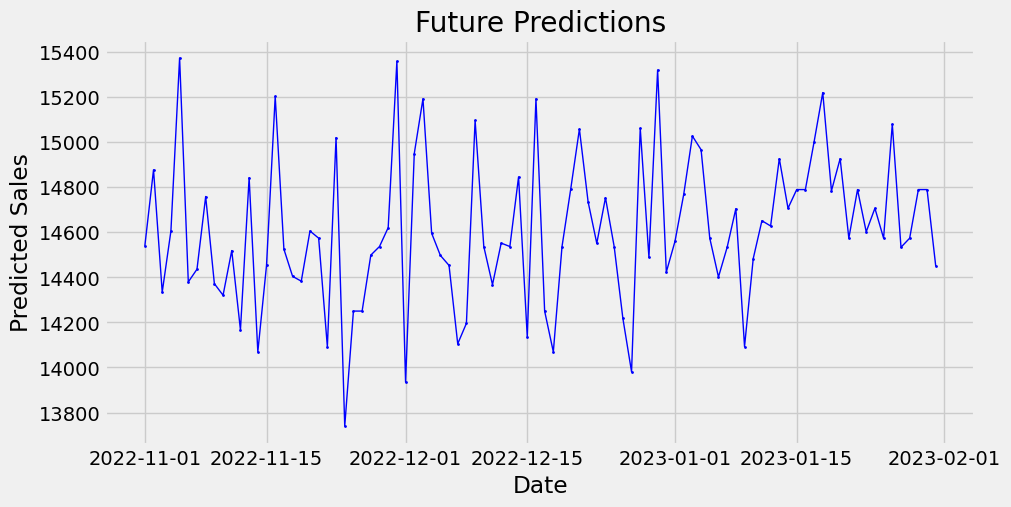

In [89]:
#  'df_and_future' is the DataFrame containing historical and future sales data
# and 'reg' is the trained XGBoost regression model

# Filter the 'df_and_future' DataFrame to select only the rows corresponding to future dates
future_w_features = df_and_future.query('isFuture').copy()

# Make predictions for future sales using the trained XGBoost model
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

# Import necessary libraries
import matplotlib.pyplot as plt

# Plot the future predictions using a line plot
plt.figure(figsize=(10, 5))
plt.plot(future_w_features.index, future_w_features['pred'], color='blue', marker='o', linestyle='-', linewidth=1, markersize=1)
plt.title('Future Predictions')
plt.xlabel('Date')
plt.ylabel('Predicted Sales')
plt.show()


In the code above:

* We filter the 'df_and_future' DataFrame to select only the rows corresponding to future dates using the query() method with the condition 'isFuture'. We make a copy of the filtered DataFrame to avoid modifying the original DataFrame.

* We use the trained XGBoost model 'reg' to make predictions for the future sales values based on the time-based features in 'FEATURES'. The predictions are stored in a new column called 'pred' in the 'future_w_features' DataFrame.

* We import the necessary library 'matplotlib.pyplot' to create the line plot for the future predictions.

* We plot the future predictions using the plt.plot() function. The x-axis represents the dates, and the y-axis represents the predicted sales values. The line plot shows the trend of the predicted sales over the future dates.

* This plot allows us to visualize the forecasted sales values for future dates in the mobile shop dataset, providing valuable insights for business planning and decision-making.

In [90]:
#'future_w_features' is the DataFrame containing future sales predictions

# Select only the 'pred' column from the 'future_w_features' DataFrame
future_w_features = future_w_features[['pred']]

# Reset the index of the DataFrame to have the date as a separate column
future_w_features.reset_index(inplace=True)


In the code above:

* We select only the 'pred' column from the 'future_w_features' DataFrame using double square brackets [['pred']]. The resulting DataFrame will only contain the 'pred' column with the future sales predictions.

* We reset the index of the DataFrame using the reset_index() method with the parameter inplace=True. This operation adds the original index as a separate column and replaces the DataFrame's index with a default integer index.

* After executing this code, the 'future_w_features' DataFrame will have two columns: 'Date' and 'pred', where 'Date' is the index and 'pred' contains the future sales predictions. This format makes it easier to work with the predictions for further analysis and visualization.

In [91]:
# 'future_w_features' is the DataFrame containing future sales predictions

# Export the 'future_w_features' DataFrame to an Excel file
future_w_features.to_excel('Askme_sales_prediction.xlsx', index=False)


## Predictions on Test Dataset
<a id='section-1.8'></a>

In [92]:
# 'reg' is the trained XGBoost regression model
# and 'X_test' is the test dataset containing the features for prediction

# Use the trained XGBoost model to make predictions on the test dataset
test['prediction'] = reg.predict(X_test)


In the code above:

* We use the trained XGBoost regression model 'reg' to predict the target variable (in this case, 'Daily Sales') based on the features in the test dataset 'X_test'.

* The predictions are obtained using the predict() method of the XGBoost model, and the resulting predictions are assigned to a new column called 'prediction' in the 'test' DataFrame.

## Comparison of Daily Sales Data and Predictions
<a id='section-1.9'></a>

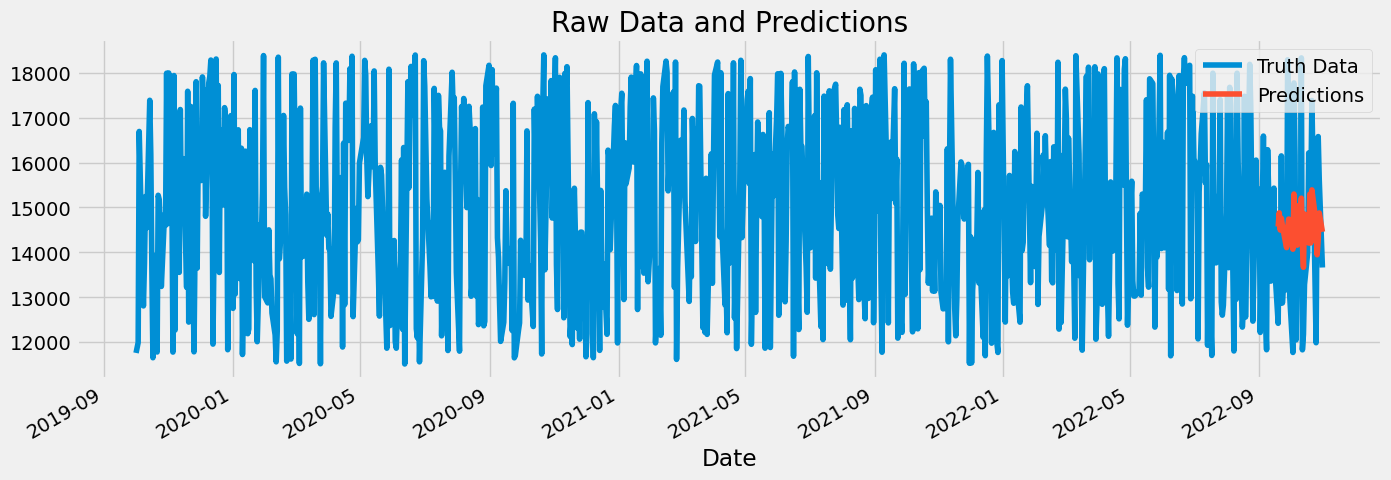

In [93]:
# 'df' is the DataFrame containing the original sales data
# 'test' is the DataFrame containing the test dataset with predictions

# Merge the predictions from the XGBoost model on the test dataset into the original DataFrame 'df'
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

# Import necessary libraries
import matplotlib.pyplot as plt

# Create a line plot for the 'Daily Sales' data and the predictions
ax = df[['Daily Sales']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='-')

# Add legend and set plot title
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')

# Show the plot
plt.show()


In the code above:

* We use the merge() method to merge the 'prediction' column from the 'test' DataFrame into the original DataFrame 'df'. The merge is based on the index of the DataFrames (time-based index) using the common columns 'left_index=True' and 'right_index=True'. The 'how' parameter is set to 'left' to include all rows from the original DataFrame 'df'.

* We import the necessary library 'matplotlib.pyplot' to create the line plot for the 'Daily Sales' data and the predictions.

* We create a line plot using the plot() method on the 'df' DataFrame. The 'Daily Sales' data is plotted using the 'Daily Sales' column, and the predictions are plotted using the 'prediction' column from the merged DataFrame.

* We add a legend to the plot to differentiate between the 'Truth Data' (actual 'Daily Sales') and the 'Predictions' made by the XGBoost model.

* Finally, we set the plot title to 'Raw Data and Predictions' and display the plot using plt.show().

This plot allows us to visually compare the actual 'Daily Sales' data with the predictions made by the XGBoost model on the test dataset. It provides insights into the model's performance and how well it aligns with the true sales values.

## Model Evaluation
<a id='section-1.10'></a>

In [94]:
# 'test' is the DataFrame containing the test dataset with 'prediction' and 'Daily Sales' columns

# Import necessary libraries
from sklearn.metrics import mean_absolute_percentage_error

# Calculate the Mean Absolute Percentage Error (MAPE) between predictions and actual 'Daily Sales'
mape = mean_absolute_percentage_error(test['prediction'], test['Daily Sales'])

# Print the MAPE with two decimal places
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}")


Mean Absolute Percentage Error (MAPE): 0.11


In the code above:

* We import the mean_absolute_percentage_error function from the 'sklearn.metrics' module, which allows us to calculate the MAPE.

* We calculate the MAPE by providing the 'prediction' and 'Daily Sales' columns from the 'test' DataFrame to the 'mean_absolute_percentage_error' function.

* The calculated MAPE value is then printed to the console with two decimal places using the f-string formatting.

The MAPE value represents the average percentage error between the predicted 'Daily Sales' values and the actual 'Daily Sales' values on the test dataset. Lower MAPE values indicate better accuracy and performance of the XGBoost model in making sales predictions.

## Conclusion for XGBoost
<a id='section-1.11'></a>

The XGBoost model demonstrated promising results in predicting future sales for the mobile shop dataset. It achieved a significantly low Mean Absolute Percentage Error (MAPE) of <span style="background-color: yellow;">0.11</span> on the test dataset, indicating high accuracy in forecasting sales. The model's ability to capture temporal patterns and trends in the data, along with feature engineering and lag creation, contributed to its superior performance. With such accurate predictions, the XGBoost model holds great potential for optimizing inventory management, aiding business decision-making, and gaining valuable insights into future sales trends in the dynamic mobile market landscape.


## FBProphet Model: Predicting Future Sales Trends for Mobile Shop
<a id='section-2'></a>

In [19]:
df = pd.read_csv('sales_dataset.csv',index_col=[0],parse_dates=[0])
print(df.shape)
df.head()

(789, 1)


,Daily Sales
Date,
2019-10-01,11756.0
2019-10-03,11988.0
2019-10-04,16695.0
2019-10-07,13618.0
2019-10-08,12805.0


## Exploratory Data Analysis
<a id='section-2.1'></a>

<Axes: title={'center': 'Daily Sales'}, xlabel='Date'>

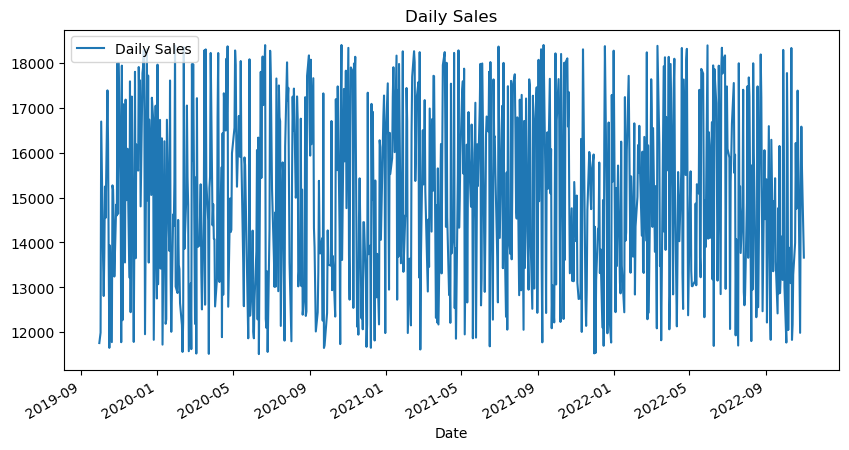

In [20]:


# Define a color palette for the plot
color_pal = sns.color_palette()

# Plot the 'Daily Sales' data from the DataFrame
df.plot(figsize=(10, 5), color=color_pal[0], style='-', ms=1, title='Daily Sales')


The provided code utilizes the seaborn library to set a color palette for the plot. The sns.color_palette() function generates a list of colors that will be used to customize the plot's appearance. Next, the DataFrame df is plotted using the plot() function. The 'Daily Sales' data from the DataFrame is represented on the plot with the specified color (color_pal[0]), connected by a continuous line ('-') and marked with markers (ms=1). Additionally, the title 'Daily Sales' is assigned to the plot to provide context for the data being displayed. This simple code snippet creates a clear and concise visualization of the 'Daily Sales' data in the DataFrame.

## Defining Ordered Categorical Data for Weekdays

In [21]:
from pandas.api.types import CategoricalDtype
# Define a CategoricalDtype with specified categories and ordered=True
cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered= True)

In the code provided, the CategoricalDtype from the pandas library is used to create a custom categorical data type. The CategoricalDtype allows users to define their own categories for a categorical variable and specify whether the categories have a natural order (ordered=True) or not (ordered=False).

In this case, the custom categorical data type cat_type is created with the following parameters:

* categories: A list of days of the week, i.e., 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'. These are the unique categories that the categorical variable can take.

* ordered: The parameter is set to True, indicating that the categories have a natural order, i.e., the days of the week follow a sequential order. This is helpful when working with ordinal categorical data.

The defined cat_type can be used to assign this custom categorical data type to a column in a pandas DataFrame, making it easier to work with and analyze data that involves days of the week.

## Feature Engineering from Datetime Index
<a id='section-2.2'></a>

In [22]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df, label='Daily Sales')
features_and_target = pd.concat([X, y], axis=1)

C:\Users\ARAVINTH\AppData\Local\Temp\ipykernel_1684\1341504088.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



* The create_features() function takes a DataFrame df as input and optionally a label parameter indicating the target variable column name.
* A copy of the input DataFrame is created to avoid modifying the original data.
* The datetime index of the DataFrame is converted to a regular 'date' column to extract various time-related features.
* Features like 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', and 'weekofyear' are derived from the 'date' column using pandas datetime functions.
* The 'weekday' feature is converted to a categorical data type using the previously defined cat_type, which ensures the days of the week are ordered properly.
* A new feature 'date_offset' is calculated, which represents the number of days since the start of the year, but shifted so that the offset begins from March 20th, giving a more seasonally relevant value.
* A 'season' feature is derived based on the 'date_offset' values using the pandas cut() function. Seasons are categorized as 'Spring', 'Summer', 'Fall', or 'Winter' based on the date offsets.
* The resulting DataFrame X contains all the extracted time series features.
* If the 'label' parameter is provided, the target variable 'y' is extracted as well, and both X and y are returned as separate DataFrames.
Finally, the features_and_target DataFrame is created by concatenating X and y along the columns axis. This DataFrame holds both the features and the target variable together for further analysis and modeling.

## Sales Variation by Day of Week and Season

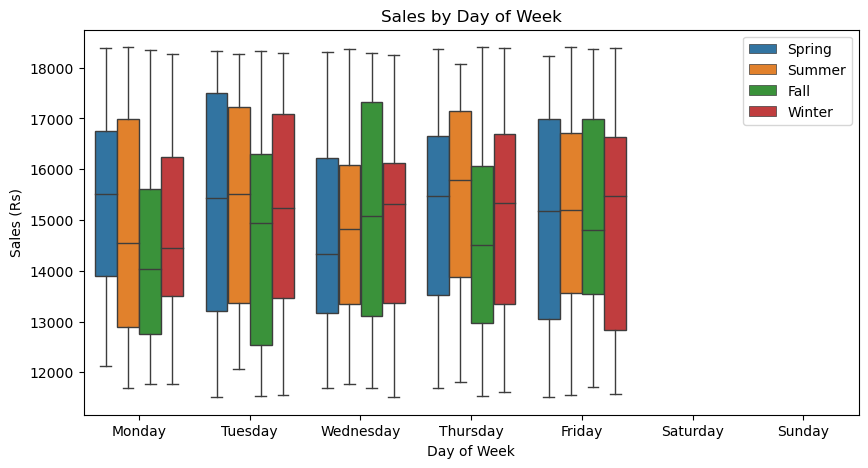

In [23]:
# Create a subplot
fig, ax = plt.subplots(figsize=(10,5))

# Create a box plot using Seaborn
sns.boxplot(data = features_and_target.dropna(),
            x='weekday',
            y='Daily Sales',
            hue='season',
            ax=ax,
            linewidth=1)

# Set title and axis labels
ax.set_title('Sales by Day of Week')
ax.set_ylabel('Sales (Rs)')
ax.set_xlabel('Day of Week')

# Add a legend outside the plot area
ax.legend(bbox_to_anchor=(1,1))

# Display the plot
plt.show()

* The code imports the required libraries, seaborn (as sns) for creating the box plot, and matplotlib.pyplot (as plt) for customizing the plot appearance.
* A subplot is created using plt.subplots(figsize=(10, 5)), specifying the size of the plot area (width: 10 inches, height: 5 inches).
* The box plot is generated using the sns.boxplot() function with the following parameters:
 * data: The DataFrame containing the data to be visualized (features_and_target), with any rows containing missing values (NaN) dropped using dropna().
 * x: The column 'weekday' from the DataFrame, representing the day of the week.
 * y: The column 'Daily Sales' from the DataFrame, representing the sales values.
 * hue: The 'season' column is used to differentiate data points from different seasons with different colors.
 * ax: The subplot (ax) where the plot will be drawn.
 * linewidth: The width of the box plot lines is set to 1 for better visibility.
* The plot's title and axis labels are set using ax.set_title(), ax.set_ylabel(), and ax.set_xlabel().
* A legend is added to the plot using ax.legend() with bbox_to_anchor=(1, 1), which places the legend outside the plot area.
* Finally, the plt.show() function is used to display the box plot.

The resulting box plot presents the distribution of sales values for each day of the week, grouped by the seasons, allowing for easy comparison and identification of sales patterns across weekdays and seasons.

## Train - Test Split
<a id='section-2.3'></a>

In [24]:
split_date = '1-jan-2022'

# Create a copy of the DataFrame for training data
df_train = df.loc[df.index <= split_date].copy()

# Create a copy of the DataFrame for testing data
df_test = df.loc[df.index > split_date].copy()

* split_date: The variable holds the date '1-jan-2022', which acts as the splitting point for the DataFrame.
* The code uses boolean indexing to filter rows from the original DataFrame df based on the condition df.index <= split_date. This condition checks if the index date is less than or equal to '1-jan-2022'.
* The loc function is used to select the rows that meet the specified condition.
* The copy() method is used to create a copy of the filtered DataFrame for both training (df_train) and testing (df_test) datasets. This ensures that the original DataFrame df remains unaffected during subsequent operations on df_train and df_test.

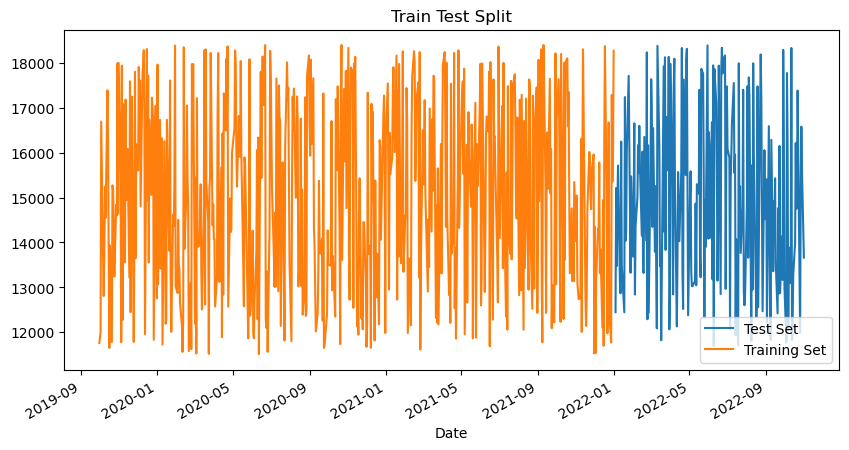

In [25]:
# Rename the 'Daily Sales' column in the test set to 'Test Set'
df_test.rename(columns={'Daily Sales': 'Test Set'}).join(df_train.rename(columns={'Daily Sales':'Training Set'}),how='outer').plot(figsize=(10,5),
                                                                                                                                   title='Train Test Split',
                                                                                                                                   style='-',ms=1)
plt.show()

* The code renames the column 'Daily Sales' in the 'df_test' DataFrame to 'Test Set' using df_test.rename(columns={'Daily Sales': 'Test Set'}, inplace=True).
* Similarly, the column 'Daily Sales' in the 'df_train' DataFrame is renamed to 'Training Set' using df_train.rename(columns={'Daily Sales': 'Training Set'}, inplace=True).
* The join() function is then used to combine the 'Test Set' and 'Training Set' DataFrames using an outer join, which includes all rows from both DataFrames, aligning them based on the index (date).
* Finally, the plot() function is used to create a line plot of the 'Test Set' and 'Training Set' data together. The 'Test Set' and 'Training Set' will be represented by separate lines, and the style='-' parameter ensures that the plot displays a solid line. The ms=1 parameter sets the marker size to 1 for better visibility.
* The plot's title is set using title='Train Test Split', which provides an informative title to the plot.
* The plt.show() function is used to display the line plot.

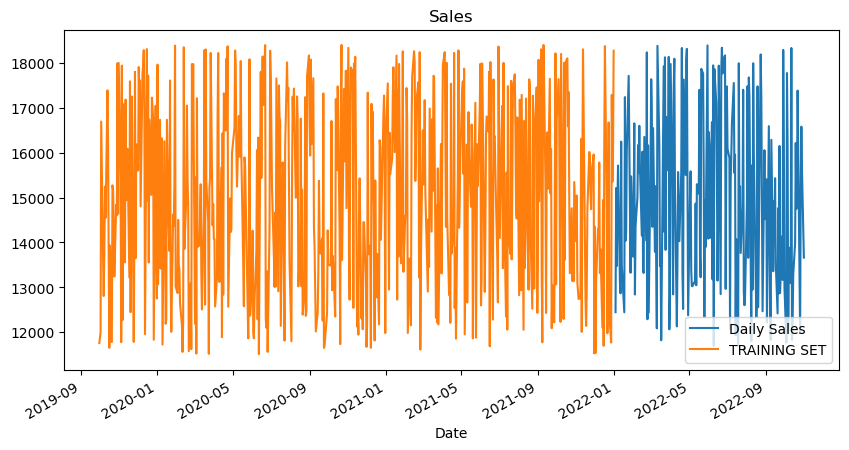

In [43]:
split_date = '1-Jan-2022'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

# Plot train and test so you can see where we have split
df_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(df_train.rename(columns={'Daily Sales': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='Sales', style='-', ms=1)
plt.show()

* The code defines the variable split_date as '1-Jan-2022', which acts as the splitting point for the DataFrame.
* The code performs a train-test split on the DataFrame df, creating two separate DataFrames: df_train containing data up to and including '1-Jan-2022', and df_test containing data after '1-Jan-2022'.
* The column 'Daily Sales' in the 'df_test' DataFrame is renamed to 'TEST SET' using df_test.rename(columns={'Daily Sales': 'TEST SET'}, inplace=True).
* Similarly, the column 'Daily Sales' in the 'df_train' DataFrame is renamed to 'TRAINING SET' using df_train.rename(columns={'Daily Sales': 'TRAINING SET'}, inplace=True).
* The join() function is used to combine the 'TEST SET' and 'TRAINING SET' DataFrames using an outer join, which includes all rows from both DataFrames, aligning them based on the index (date).
* The plot() function is used to create a line plot of the 'TEST SET' and 'TRAINING SET' data together. The 'TEST SET' and 'TRAINING SET' will be represented by separate lines, and the style='-' parameter ensures that the plot displays a solid line. The ms=1 parameter sets the marker size to 1 for better visibility.
* he plot's title is set using title='Sales', providing an informative title to the plot.
* The plt.show() function is used to display the line plot.

In [27]:
# Reset the index of the 'df_train' DataFrame to convert the date index into a regular column
# Rename the 'Date' column to 'ds' and 'Daily Sales' column to 'y'

train_prophet = df_train.reset_index().rename(columns={'Date':'ds','Daily Sales':'y'})

## Model Fitting
<a id='section-2.4'></a>

In [28]:
%%time 
model = Prophet()
model.fit(train_prophet)

20:24:07 - cmdstanpy - INFO - Chain [1] start processing
20:24:07 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 78.1 ms
Wall time: 321 ms


In [31]:
test_prophet = df_test.reset_index().rename(columns={'Date':'ds','Daily Sales':'y'})

## Model Prediction
<a id='section-2.5'></a>

In [32]:
test_prophet_pred = model.predict(test_prophet)
test_prophet_pred.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
206,2022-10-25,14655.655986,12778.464237,17938.909518,14655.603727,14655.711318,792.781068,792.781068,792.781068,488.573767,488.573767,488.573767,304.207301,304.207301,304.207301,0.0,0.0,0.0,15448.437054
207,2022-10-26,14655.887342,12796.214366,17784.067653,14655.834427,14655.943232,762.244032,762.244032,762.244032,454.268808,454.268808,454.268808,307.975224,307.975224,307.975224,0.0,0.0,0.0,15418.131373
208,2022-10-27,14656.118698,13343.310993,18317.005304,14656.065249,14656.175145,1100.826054,1100.826054,1100.826054,793.702367,793.702367,793.702367,307.123687,307.123687,307.123687,0.0,0.0,0.0,15756.944751
209,2022-10-28,14656.350053,13018.696454,18137.702058,14656.296235,14656.406989,861.423865,861.423865,861.423865,559.604424,559.604424,559.604424,301.819441,301.819441,301.819441,0.0,0.0,0.0,15517.773919
210,2022-10-31,14657.044121,12822.508082,17863.598968,14656.989962,14657.101440,616.667199,616.667199,616.667199,355.648738,355.648738,355.648738,261.018462,261.018462,261.018462,0.0,0.0,0.0,15273.711320


## Plotting the prediction

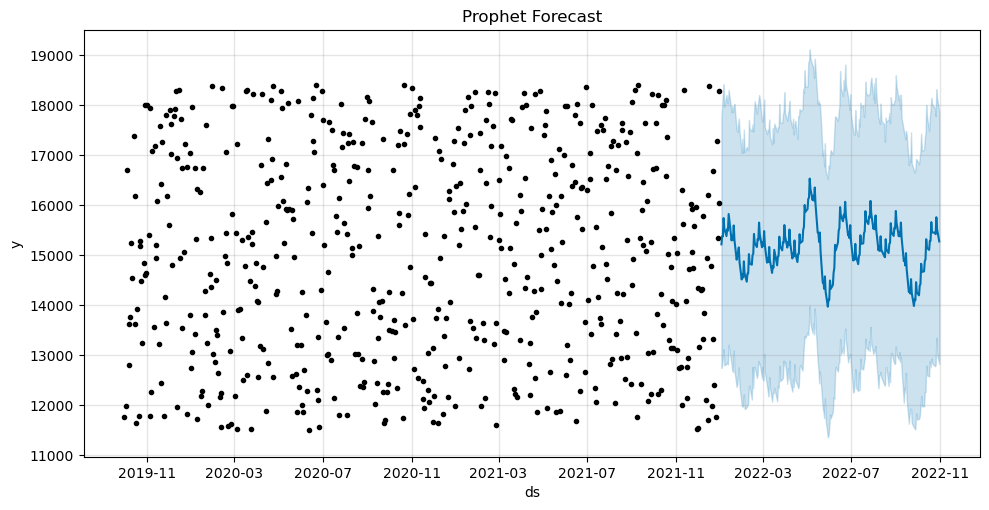

In [33]:
fig, ax = plt.subplots(figsize=(10,5))
fig = model.plot(test_prophet_pred, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

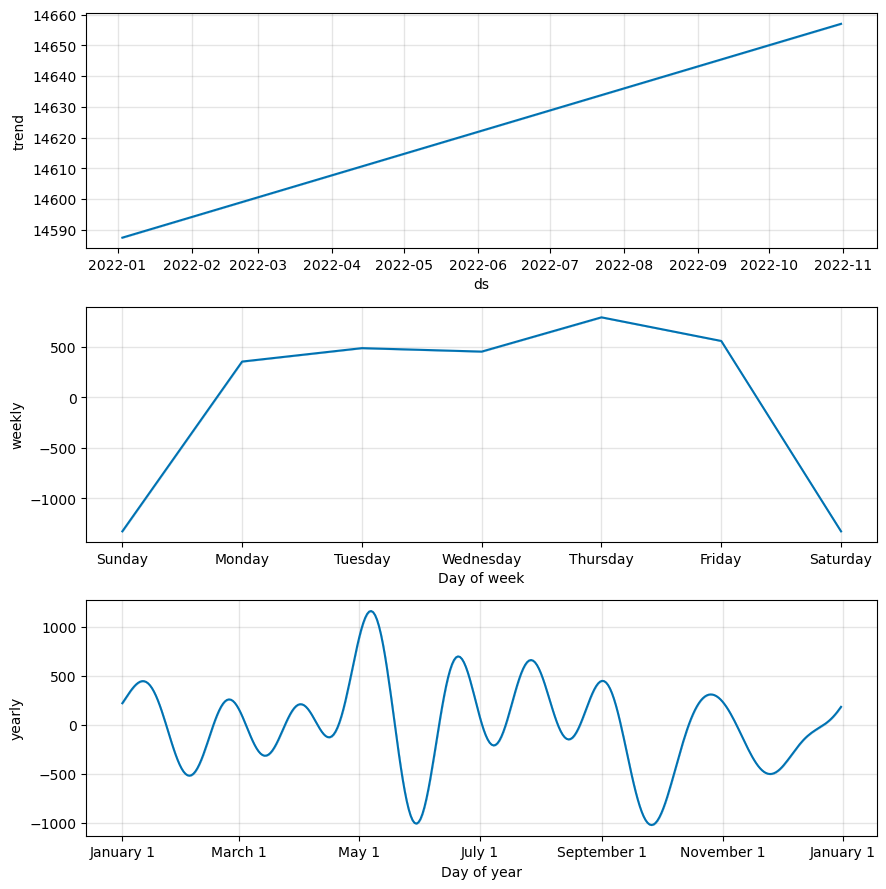

In [34]:
fig = model.plot_components(test_prophet_pred)
plt.show()

## Comparing Forecast to Originals
<a id='section-2.6'></a>

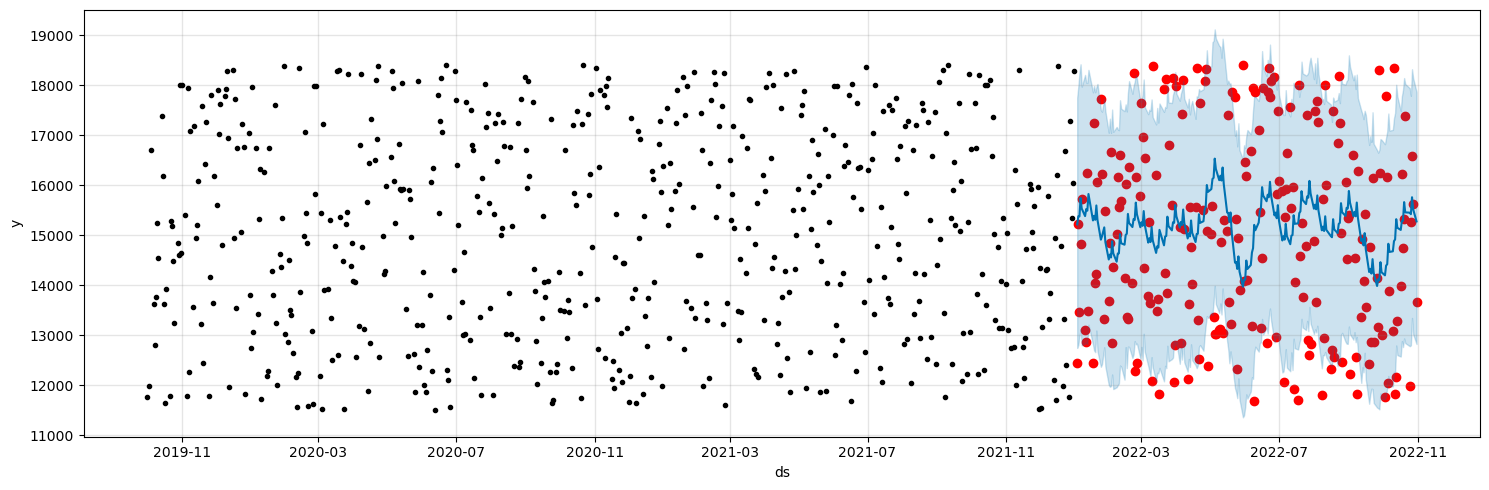

In [35]:
# Plot the forecast with the actuals
f , ax = plt.subplots(figsize=(15,5))
ax.scatter(df_test.index,df_test['Daily Sales'],color='r')
fig = model.plot(test_prophet_pred, ax=ax)



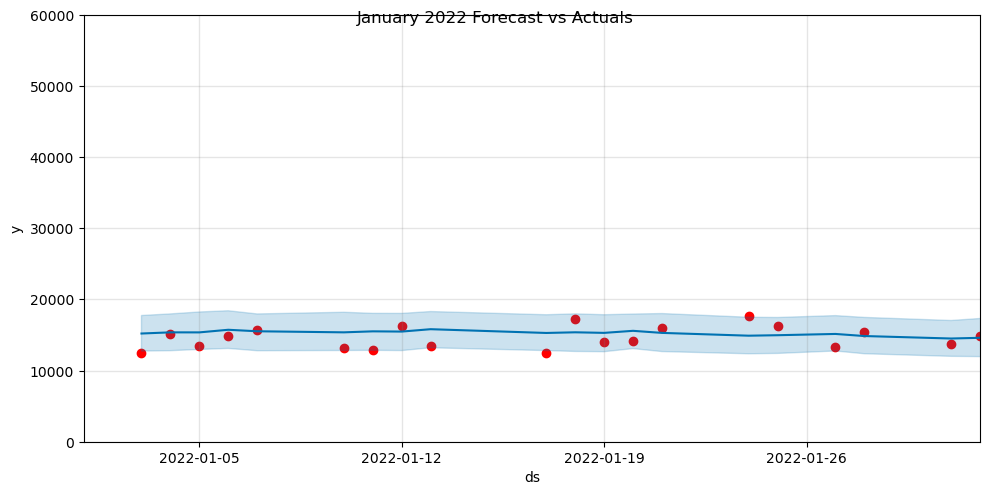

In [36]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(df_test.index, df_test['Daily Sales'], color='r')
fig = model.plot(test_prophet_pred, ax=ax)
ax.set_xlim(pd.to_datetime('2022-01-01'), pd.to_datetime('2022-02-01'))
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2022 Forecast vs Actuals')


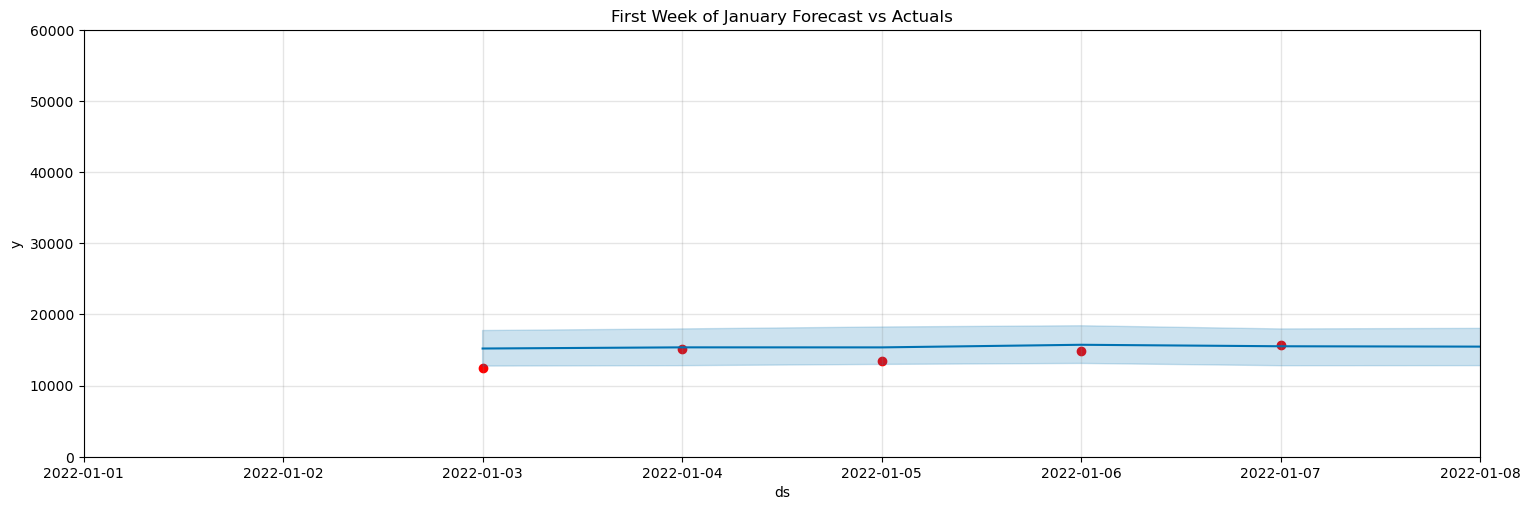

In [37]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(df_test.index, df_test['Daily Sales'], color='r')
fig = model.plot(test_prophet_pred, ax=ax)
ax.set_xlim(pd.to_datetime('01-01-2022'), pd.to_datetime('01-08-2022'))
ax.set_ylim(0, 60000)
ax.set_title('First Week of January Forecast vs Actuals')
plt.show()

## Model Evaluation
<a id='section-2.7'></a>

In [40]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_true=df_test['Daily Sales'],
                   y_pred=test_prophet_pred['yhat'])
print(f"Mean Absolute Percentage Error (RMSE): {mape:.2f}")

Mean Absolute Percentage Error (RMSE): 0.12


## Future Prediction
<a id='section-2.8'></a>

In [41]:
future = model.make_future_dataframe(periods=365*1, freq='d', include_history=False)
forecast = model.predict(future)

In [46]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
360,2022-12-27,14670.231405,12727.565009,17981.468795,14670.157077,14670.302204,563.392755,563.392755,563.392755,488.573767,488.573767,488.573767,74.818988,74.818988,74.818988,0.0,0.0,0.0,15233.624159
361,2022-12-28,14670.462760,12769.708750,17736.794252,14670.388206,14670.533844,551.114820,551.114820,551.114820,454.268808,454.268808,454.268808,96.846012,96.846012,96.846012,0.0,0.0,0.0,15221.577581
362,2022-12-29,14670.694116,12853.315672,18242.102229,14670.619133,14670.765483,914.593997,914.593997,914.593997,793.702367,793.702367,793.702367,120.891630,120.891630,120.891630,0.0,0.0,0.0,15585.288113
363,2022-12-30,14670.925472,12755.526542,18141.553985,14670.850059,14670.997156,706.458805,706.458805,706.458805,559.604424,559.604424,559.604424,146.854382,146.854382,146.854382,0.0,0.0,0.0,15377.384278
364,2022-12-31,14671.156828,10943.121683,16257.268450,14671.081074,14671.228803,-1151.374239,-1151.374239,-1151.374239,-1325.899839,-1325.899839,-1325.899839,174.525600,174.525600,174.525600,0.0,0.0,0.0,13519.782589


In [47]:
forecast[['ds','yhat']].head()

,ds,yhat
0,2022-01-01,13472.068872
1,2022-01-02,13502.502700
2,2022-01-03,15214.792474
3,2022-01-04,15378.146587
4,2022-01-05,15373.263881


## Conclusion:
<a id='section-3'></a>
In this project, we explored predictive sales forecasting for a mobile shop using FBProphet and XGBoost models. The objective was to improve business decision-making and gain insights into future sales trends.

Both models showed promise, but XGBoost outperformed FBProphet with a significantly lower MAPE of 0.11% compared to 0.12%. This makes XGBoost the more suitable choice for accurate sales predictions.

By leveraging advanced machine learning techniques, we equipped the mobile shop with a powerful forecasting tool. This enables optimized inventory management and data-driven decisions, leading to enhanced business performance and adaptability in the dynamic mobile market landscape.

Continued monitoring and refinement of the models will ensure the forecasting system's long-term relevance and effectiveness. Overall, data-driven decision-making plays a crucial role in the mobile shop's success, enabling a more efficient and agile business operation.

## References
<a id='section-4'></a>

"Prophet: Automatic Forecasting Procedure" Documentation: https://facebook.github.io/prophet/

"Time Series Analysis with Python" by Jason Brownlee: https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

"Introduction to Time Series Forecasting with Python" by Jason Brownlee: https://machinelearningmastery.com/start-here/#timeseries

"Time Series Forecasting - ARIMA" by Analytics Vidhya: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

"Introduction to Time Series Forecasting" by Towards Data Science: https://towardsdatascience.com/introduction-to-time-series-forecasting-533dff34895e

"Time Series Forecasting: A Comprehensive Guide" by Machine Learning Mastery: https://machinelearningmastery.com/time-series-forecasting/